# Google Cloud CMIP6 Public Data: Basic Python Example

Edited from: [Pangeo](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html)

This notebooks shows how to query the catalog and load the data using Python

In [1]:
from matplotlib import pyplot as plt, animation
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import zarr
import fsspec

%matplotlib notebook
#%matplotlib widget
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6

## Browse Catalog

The data catatalog is stored as a CSV file. Here we read it with Pandas.

The columns of the dataframe correspond to the CMIP6 controlled vocabulary. A beginners' guide to column names is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q). The variables are explained in [this document](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271).

In [290]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print(f'Number of available models: {np.unique(df["source_id"]).shape[0]}')
df.head()

Number of available models: 88


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


#### Choose model

First, we will select one climate model from the roughly 100 available models. Specifically, we will select the **NCAR-CESM2 model**, as it is one of the most widely used climate models, offers 1° spatial and monthly resolution

In [397]:
# NCAR: National Center for Atmospheric Research
# CESM: Community Earth System Model
df_cesm = df.query('institution_id == "NCAR"'\
                    '& source_id == "CESM2"')
# df_cesm.head()

#### Choose scenarios

To get started, we will choose the some scenarios that focus on emission pathways--the same as in ClimateBench by Watson-Parris et al.

In [398]:
df_cesm_em = df_cesm.query('(experiment_id == "ssp126") '\
                           ' | (experiment_id == "ssp245")'\
                           ' | (experiment_id == "ssp370")'\
                           ' | (experiment_id == "ssp585")'\
                           ' | (experiment_id == "historical")'\
                           ' | (experiment_id == "abrupt4xCO2")'\
                           ' | (experiment_id == "1pctCO2")'\
                           ' | (experiment_id == "piControl")'\
                           ' | (experiment_id == "hist-GHG")'\
                           ' | (experiment_id == "hist-aer")')
# I think, each experiment is uniquely assigned to an activity so we don't need to select for that
# df_cesm_mip = df_cesm.query('(activity_id == "DAMIP")'\
#                            ' | (activity_id == "ScenarioMIP")'\
#                            ' | (activity_id == "CMIP")')

In [399]:
from IPython.display import Markdown as md

md(f'Note, however that the CESM2 model was run for **{np.unique(df_cesm["experiment_id"]).shape[0]} scenarios**, also called experiments. '\
    'The experiments are potentially highly correlated and contain missing values, but '\
    'the number of experiments provides an **upper bound on the number of data points** we have. '\
    'A full list of activities and experiments is here:<br><br>'\
    f'Experiments: <br>'+', '.join(np.unique(df_cesm['experiment_id'])))

Note, however that the CESM2 model was run for **46 scenarios**, also called experiments. The experiments are potentially highly correlated and contain missing values, but the number of experiments provides an **upper bound on the number of data points** we have. A full list of activities and experiments is here:<br><br>Experiments: <br>1pctCO2, 1pctCO2-4xext, 1pctCO2-bgc, 1pctCO2-cdr, 1pctCO2-rad, 1pctCO2to4x-withism, abrupt-0p5xCO2, abrupt-2xCO2, abrupt-4xCO2, amip, amip-4xCO2, amip-future4K, amip-hist, amip-m4K, amip-p4K, aqua-4xCO2, aqua-control, aqua-p4K, deforest-globe, esm-hist, esm-piControl, futSST-pdSIC, hist-GHG, hist-aer, hist-nat, hist-noLu, historical, land-hist, land-noLu, lig127k, omip1, pdSST-futAntSIC, pdSST-futArcSIC, pdSST-pdSIC, pdSST-piAntSIC, pdSST-piArcSIC, piClim-4xCO2, piClim-aer, piClim-control, piControl, piSST-pdSIC, piSST-piSIC, ssp126, ssp245, ssp370, ssp585

The experiments have been run for various activities, also called model intercomparison projects (MIP). For example, CMIP, ScenarioMIP or DAMIP. I think, each experiment is uniquely assigned to one activity. 

#### Choose variables

For demonstration, we will choose carbon-dioxide (co2) and near surface air temperature (tas). Other greenhouse cases (ghg), such as methane (ch4) and sulfux dioxide (so2) are in the cesm dataset, but only not for the selected future scenarios. More data exploration needs to be done to the largest set of overlapping scenarios and variables.

In [408]:
df_ghg_cesm_em = df_cesm_em.query("((variable_id == 'co2') & (table_id == 'Amon'))"\
                           "| (variable_id == 'tas') & (table_id == 'Amon')")

print(f'There are {np.unique(df_cesm["variable_id"]).shape[0]} variables in the CMIP CESM data.')
df_ghg_cesm_em.sort_values('experiment_id').head()

There are 331 variables in the CMIP CESM data


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
377165,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20191105
78810,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20190425
377438,DAMIP,NCAR,CESM2,hist-GHG,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r3i...,NaN,20191106
377388,DAMIP,NCAR,CESM2,hist-GHG,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r2i...,NaN,20191106
377183,DAMIP,NCAR,CESM2,hist-GHG,r2i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r2i...,NaN,20191105


In [406]:
# Emissions that are in ClimateBench and CMIP6 CESM:
## co2: Mole Fraction of CO2 [mol mol-1]
## ch4global: Global Mean Mole Fraction of CH4 [1e-09]
## so2: SO2 Volume Mixing Ratio [mol mol-1]
# ------
# Other emission data that is in CMIP6 CESM but not in ClimateBench
## n2oglobal: Global Mean Mole Fraction of N2O [1e-09]
## cfc11global: Global Mean Mole Fraction of CFC11 [1e-12]
## cfc12global: Global Mean Mole Fraction of CFC12 [1e-12]
## o3: Mole Fraction of O3 [mol mol-1]
## rsds: Surface Downwelling Shortwave Radiation [W m-2]
# Other emission data that is in ClimateBench but not in CMIP6 CESM
## black carbon

#### Choose realization

Lastly, we select a member or realization within the ensemble. I am not sure what 'realizations' refers to but it is a choice we have.

In [412]:
print(f'There are {df_ta_cesm.shape[0]} different ensemble members for the historical scenario')
df_ta_cesm = df_ghg_cesm_em.query('member_id == "r1i1p1f1"')

df_ta_cesm.sort_values('experiment_id')

There are 11 different ensemble members for the historical scenario


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
78810,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20190425
377165,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20191105
245913,DAMIP,NCAR,CESM2,hist-GHG,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r1i...,NaN,20190730
377180,DAMIP,NCAR,CESM2,hist-GHG,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r1i...,NaN,20191105
415012,DAMIP,NCAR,CESM2,hist-aer,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-aer/r1i...,NaN,20200206
59875,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
377207,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20191105
67584,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20190320
409585,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20200124
246157,ScenarioMIP,NCAR,CESM2,ssp245,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20190730


#### Store data

To create some visualizations and demonstrate storing, we will choose **monthly surface air temperature** for historical experiments.

In [414]:
# Amon: Monthly Atmospheric Data
# tas: Near-surface Air Temperature
# historical: Data from industrial revolution until now
df_ta_cesm = df_ta_cesm.query("table_id == 'Amon' & "\
                 "variable_id == 'tas' & "\
                 "experiment_id == 'historical'")
df_ta_cesm.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
59875,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


## Load Data

Now we will load a single store using fsspec, zarr, and xarray.

In [415]:
# Get the Google Cloud path to sub-selected dataset
zstore = df_ta_cesm.zstore.values[0] # e.g., gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190514/

# Create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# Open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)

### Print some data statistics

In [416]:
print(f'The data spans {np.unique(ds["time.year"]).shape[0]} years from '\
      f'{ds["time.year"].min().values} to {ds["time.year"].max().values} with '\
      f'{np.unique(ds["time.month"]).shape[0]} months per year')
print(f'One variable {ds.tas.long_name} occupies {ds.tas.nbytes / 1024. / 1024.}MB as {ds.tas.dtype}')
ds
# df_ta_cesm.head()


The data spans 165 years from 1850 to 2014 with 12 months per year
One variable Near-Surface Air Temperature occupies 417.65625MB as float32


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 ...
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object ...
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                15
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/d9a7225a-49c3-4470-b7ab-a8180926f839
    version_id:             v20190308

### Store surface air temperature

In [265]:
ds.tas.to_netcdf("surface_temp.nc")
# Store as numpy files
# latitude = ds.tas.lat
# longitude = ds.tas.lon
# time = ds.tas.time
# np.save("surface_temp.npy", ds.tas.as_numpy() # (time,lat, lon))
# np.save("time.npy", time.as_numpy())
# ...

### Load data

In [266]:
from matplotlib import pyplot as plt, animation
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
tas = xr.open_dataset("surface_temp.nc")

### Plot sample year

(<Figure size 432x288 with 2 Axes>,
 <GeoAxesSubplot:title={'left':'Near-Surface Air Temp. Anomaly (in °C) in 1850.'}>,
 <matplotlib.image.AxesImage at 0x7fd7b84d99d0>)

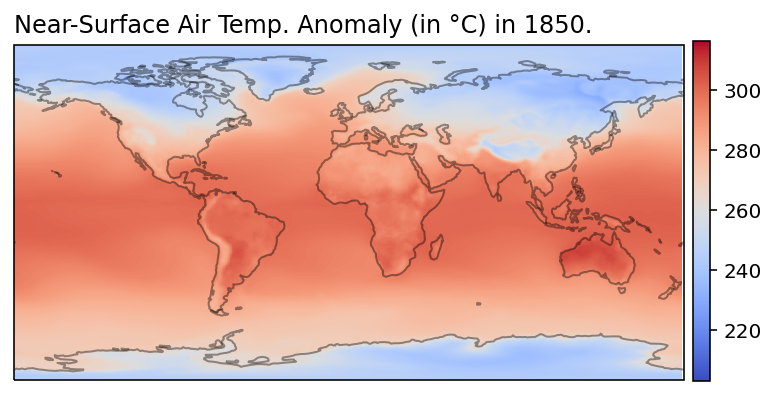

In [267]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
tas.coords['lon'] = (tas.coords['lon'] + 180) % 360 - 180
tas = tas.sortby(tas.lon)

def get_title_tas(idx, data):
    """ Returns the title for the surface temp. plot at idx
    """
    title = f"Near-Surface Air Temp. Anomaly (in °C) in "\
             f"{data.time[idx].dt.year.values}."
     #f"{months[time[idx].dt.month.values-1]}. "\
     #f"{months[data.time[idx].dt.month.values-1]}.",
    return title 

def init_plt(data, idx=0):
    """ Initializes figures and plots one frame.
    """
    # TODO: find out how img should be plotted, as max(lon)==357.5 and not 360
    img_extent = (np.min(data.lon), np.max(data.lon), np.min(data.lat),np.max(data.lat))

    fig = plt.figure()
    crs = ccrs.PlateCarree()
    ax = plt.subplot(1,1,1,projection=crs)
    im = ax.imshow(data.values[idx], origin='lower', 
                   vmin=np.min(data.values), vmax=np.max(data.values),
                   cmap='coolwarm', 
                   extent=img_extent,
                   transform=crs, animated=True) # Init first frame
    im.set_data(data.values[idx,...])
    
    ax.coastlines(alpha=0.4)
    ax.set_global()

    ax.set_title(label=get_title_tas(idx,data), loc='left')

    # Place colorbar
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    cax = fig.add_axes([0.91, 0.210, 0.02, 0.59])
    fig.colorbar(im, cax=cax, orientation='vertical')
    return fig, ax, im

init_plt(tas['tas'])
# print('The plot title is false. Do not trust this frame.')
# plt.show()

# Todo: figure out a way to plot with pcolormesh. Current version of pcolormesh 
# requires clipping tas.tas, which skews the plotted values.
#im = ax.pcolormesh(tas.lon, tas.lat, tas.tas[idx,:-1,:-1], transform=crs)
#im.set_array(tas.tas[idx,1:,1:])

In [268]:
def annual_mean_from_months(ds, var):
    """
    Calculate annual mean while weighting by days in each month
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

annual_mean = annual_mean_from_months(tas, 'tas')

Queueing 165 frames in animation.


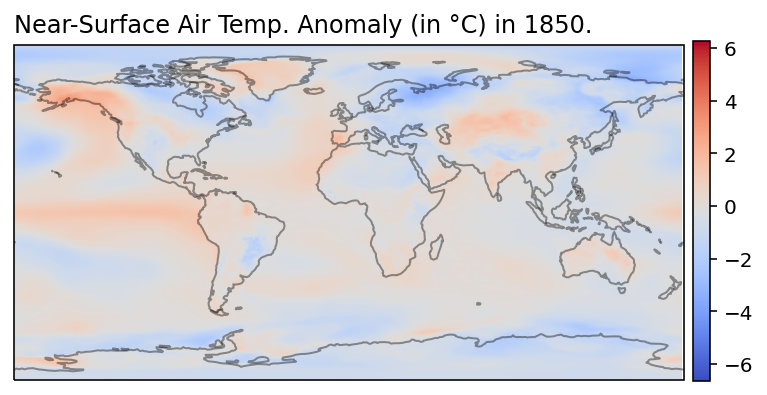

In [269]:
import sys
from tqdm import trange
from tqdm.notebook import tqdm
from IPython.display import display
from IPython.display import HTML

def init_animation(data):
    """ Initializes animation
    """
    global fig, ax, im
    fig, ax, im = init_plt(data)
    im.set_data(np.zeros(data.values[0].shape))
    return

def animate(idx,data):
    """ Adds one frame to the animation 
    """
    ax.set_title(label=get_title_tas(idx,data), loc='left')
    im.set_data(data.values[idx,...])
    #crs = ccrs.PlateCarree()
    #im = ax.pcolormesh(tas.lon, tas.lat, tas.tas[idx,:,:], transform=crs)
    #ax.coastlines(alpha=0.4)
    return im,

def create_animation(data, max_frames=None):
    """
    Creates an animation of a spatiotemporal xarray

    Args
        data xarray: Data over time, lon, lat that should be animated 
    Returns:
        anim matplotlib.animation.FuncAnimation: Animation object
    """
    interval = 1
    # Create animation
    init_animation(data)
    frames = range(data.values.shape[0]) if not max_frames else range(max_frames) # range(40)# tqdm(range(tas.shape[0]), file=sys.stdout)
    print(f'Queueing {len(frames)} frames in animation.')
    anim = animation.FuncAnimation(fig, animate, fargs=(data,),
                                   frames=frames, 
                                   interval=interval, blit=True, repeat=False)
    return anim

# Calculate annual temperature anomaly:
tas_anom = tas # todo: change ot copy 
tas_anom = annual_mean_from_months(tas_anom, 'tas')
climatology = tas_anom.mean('time')
tas_anom = tas_anom - climatology

anim = create_animation(tas_anom,max_frames=None)

### Render and save animation
This might take a while

In [270]:
%%time
anim.save('animation.mp4', writer=animation.FFMpegWriter(fps=30), dpi=150)

CPU times: user 12.5 s, sys: 4.98 s, total: 17.5 s
Wall time: 19 s


In [271]:
from IPython.display import Video
Video("animation.mp4")

# Plot annual global-mean surface air temperature

For this we need the area weighting factor for each gridpoint.

In [159]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[0]), consolidated=True)
print(f'Name: {ds_area.areacella.long_name}')
# ds_area

Name: Grid-Cell Area for Atmospheric Grid Variables


In [161]:
tas = xr.open_dataset("surface_temp.nc")
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# ta_timeseries

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [162]:
%%time
ta_timeseries.load()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.25 ms


<xarray.DataArray (time: 1980)>
array([285.3431 , 285.51422, 286.22678, ..., 288.4625 , 287.72174,
       287.05515], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

Text(0, 0.5, 'Near-Surface Air Temperature in K')

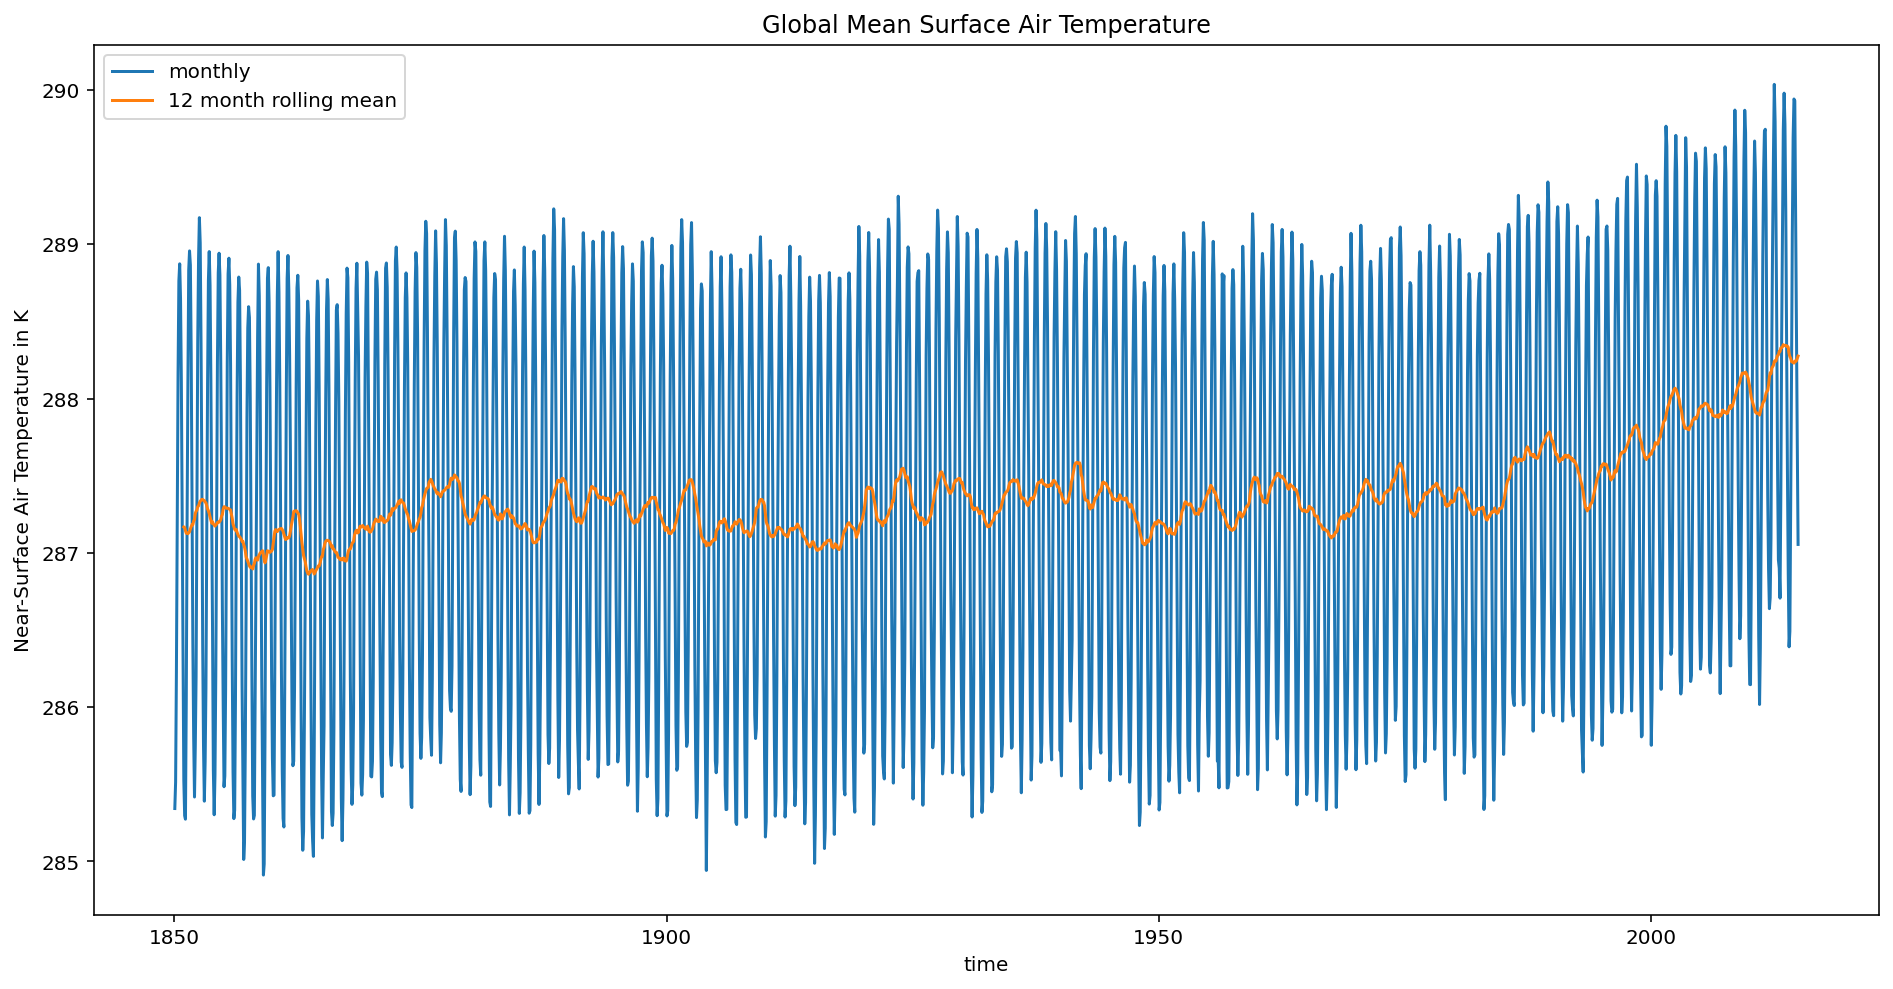

In [180]:
ta_timeseries.plot(label='monthly', figsize=(16,8))
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')
plt.ylabel(f'{ds.tas.long_name} in {ds.tas.units}')